# Quantitative Textanalyse in der Sozialen Arbeit: Topic Modeling (LDA)

Das folgende Skript stellt die Entwicklung von Themen in der Wissenschaft der Sozialen Arbeit vor. Die verwendete Methode - Latent Dirichlet Allocation (LDA) - wurde von Blei et al. (2003) entwickelt und zielt darauf ab, Themen aus großen Textkorpora zu gewinnen. Die Annahme dieser Methode ist, dass Texte (= Dokumente) Themen enthalten, die einer bestimmten Wahrscheinlichkeitsverteilung folgen. Ein Thema umfasst verschiedene Wörter, die auch einer bestimmten Wahrscheinlichkeitsverteilung folgen. Diese Methode wird als geeignetes Mittel für wissenschaftliche Studien angesehen, insbesondere für die Extraktion diskutierter Forschungsthemen sowie die Analyse der Dynamik und Diffusion der diskutierten Themen (Griffiths & Steyvers, 2004; Hall et al., 2008; McFarland et al., 2013). 

Das folgende Skript zielt darauf ab, erste Ergebnisse und Überlegungen für weitere Analysen zu präsentieren. Wir geben keine detaillierte Beschreibung der LDA. Vielmehr verweisen wir auf eine umfassende Einführung in diese Methode: http://journalofdigitalhumanities.org/2-1/dh-contribution-to-topic-modeling/ 

Übersetzt mit www.DeepL.com/Translator

### Die Analyse geht den folgenden Fragen nach.
1. Welche Themen können in den Daten ermittelt werden?
2. Wie haben sich die Themen im Laufe der Zeit entwickelt (und verbreitet)?




## 0. Packages

In [1]:
import gensim
from gensim import corpora, models, similarities, matutils
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.models.ldamulticore import LdaMulticore
import numpy as np
import pandas as pd
import logging
from itertools import chain
import dateutil
from dateutil.parser import parse
import nltk
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import glob
import os
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


## 1. Loading the Data

In [2]:
#os.chdir("/home/markus/PycharmProjects/LDA_SWRD_05.03/")
df = pd.read_csv('SWRD_data_2017_clean.csv', sep='\t')
df1 = df.groupby(['abstract']).filter(lambda df:df.shape[0] == 1)
print('Anzahl an Abstracts', len(df1))
df1.head()

Anzahl an Abstracts 42001


,Unnamed: 0,abstract,article,author,authorAff,index,journal,journalSecondary,keyWord,location,pages,pubMedID,pubYear,secondTitle
0,0,['Reviews 101 articles (published since 1964) ...,Ethnic sensitive social work practice: The sta...,"['Schlesinger, Elfriede G.', 'Devore, Wynetta']","['Schlesinger, Elfriede G., Rutgers U, School ...",1,Journal of Sociology & Social Welfare,NaN,ideological & theoretical & practice issues ex...,NaN,30.0,NaN,1995,NaN
1,1,['Discusses the social work role in addressing...,Ethnic and minority groups in Israel: Challeng...,"['Jaffe, Eliezer David']","['Jaffe, Eliezer David, Hebrew U of Jerusalem,...",2,Journal of Sociology & Social Welfare,NaN,role of social work in addressing ethnic & cul...,Israel,23.0,NaN,1995,NaN
2,2,['Illuminates the negotiation of group identit...,"Ethnic identity, intergroup relations and welf...","['Chambon, Adrienne S.', 'Bellamy, Donald F.']","['Chambon, Adrienne S., U Toronto, Faculty of ...",3,Journal of Sociology & Social Welfare,NaN,canada,Canada,27.0,NaN,1995,NaN
3,3,"['Asserts the necessity of a theory of ""tripar...",Tripartite cultural personality and ethclass a...,"['Huang, Ken']","['Huang, Ken, St Cloud State U, Social Work De...",4,Journal of Sociology & Social Welfare,NaN,utility of theory of tripartite cultural perso...,NaN,21.0,NaN,1995,NaN
4,4,['Presents a case study of attempts to establi...,Back to our roots: Towards a specialization in...,"['Reeser, Linda C.', 'Leighninger, Leslie']","['Reeser, Linda C., Western Michigan U, School...",5,Journal of Sociology & Social Welfare,NaN,specialization & activism & proposed graduate ...,NaN,19.0,NaN,1990,NaN


## 2. Datenaufbereitung & Bereinigung  

### Bei jeder quantitativen Textanalyse muss zunächst der Text aufbereitet werden. Folgende Schritte wurden in der Funktion durchgeführt. 

1. Erzeugung von Tokens 
2. Kleinschreibung der Wörter
3. Entfernen von 'stop-words' & 'sciencefic stop-words'
4. Bereinigung der Abstract Texte von Metadaten 
5. Lemmatisierung
6. Häufige Bi-Grams erzeugen 
7. Erzeugung eines Dictionaries
8. Erstellung dre Document Term Matrix 


In [7]:
def textvorbereitung_lda(dataframe_text):

    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = get_stop_words('en')
    st_words_science = ['journal', 'database', 'discussed', 'focus', 'within', 'author', 'objectives', 'objective',
                        'article', 'paper', 'publishing', 'social', 'work', 'research', 'develop', 'correlation',
                        'abstract', 'effect', 'summarizing', 'summary', 'method', 'literature', 'review',
                        'publisher', 'article', 'figure', 'source', 'reference', 'aid', 'document', 'adapted',
                        'table', 'variable', 'level', 'score', 'measure', 'treatment', 'study', 'theory', 'theoretical',
                        'argue', 'model', 'finding', 'result', 'data', 'analysis', 'published']

    lemmatizer = WordNetLemmatizer()

    texts=[]
    all_words =[]
    for f in dataframe_text:
        raw = f.lower()
        clean_raw_verlag = raw.split("(psycinfo database record (c)", 1)[0]
        clean_raw_verlag2 = clean_raw_verlag.split("adapted from the source document. ", 1)[0]
        if "the haworth press, inc" in clean_raw_verlag2:
            clean_raw_verlag3 = clean_raw_verlag2.split("the haworth press, inc")[1]
        else:
            clean_raw_verlag3 = clean_raw_verlag2
        tokens = tokenizer.tokenize(clean_raw_verlag3)
        for t in tokens:
            all_words.append(t)
        lemmata_tokens = [lemmatizer.lemmatize(t) for t in tokens]
        tokens_len = [i for i in lemmata_tokens if len(i) >= 4]
        tokens_without_num = [i for i in tokens_len if not i.isdigit()]
        stopped_tokens = [i for i in tokens_without_num if not i in en_stop]
        stopped_tokens_science = [i for i in stopped_tokens if i not in st_words_science]
        texts.append(stopped_tokens_science)

    # Compute bigrams.
    from gensim.models import Phrases
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(texts, min_count=20)
    for idx in range(len(texts)):
        for token in bigram[texts[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                texts[idx].append(token)

    # #turn toikized documents into a id - term dictionary
    dictionary = corpora.Dictionary(texts)
    # Filter out wosds that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=50, no_above=0.90)
    # #Convert tokenized documents in a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    print(dictionary)
    print('anzahl an abstracts', len(corpus))
    print('anzahl an unique tokens', len(dictionary))

    return (texts, dictionary, corpus, all_words)


data_lda = textvorbereitung_lda(df1.abstract)
texts = data_lda[0]
dictionary = data_lda[1]

dictionary.save('30_topics/dictionary_swrd_30.dict')
corpus = data_lda[2]
corpora.MmCorpus.serialize('30_topics/corpus_swrd_30.mm', corpus)
with open('30_topics/texts_swrd_30.pkl', 'wb') as f:
    pickle.dump(texts, f)

print("Anzahl aller Wörter im Corpus", len(data_lda[3]))

/usr/local/lib/python3.5/dist-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Dictionary(5202 unique tokens: ['certainly', 'sociocultural', 'educational', 'deciding', 'rationality']...)
anzahl an abstracts 42001
anzahl an unique tokens 5202
Anzahl aller Wörter im Corpus 5466792


## 3. LDA Model

### 3.1 Ermittlung der Anzahl an Topics 

Bei einem LDA-Modell muss entschieden werden, wie viele Themen durch den Algorithmus extrahiert werden sollen. Dies ist ein schwieriger Schritt, da ein hoher Wert eines Evaluationswertes nicht unbedingt mit einer präzisen menschlichen Interpretationsleistung einhergeht. So ist beispielsweise bei einer hohen Plexibilität der Themen eine sinnvolle menschliche Interpretation selten möglich (Chang et al., 2009, S. 288). Plexibilität misst, wie gut ein trainiertes Modell auf Testdaten angewendet werden kann. Zu diesem Ein weiteres entwickeltes Maß ist das Kohärenzmaß, die die Interpretationsfähigkeit von Themen berücksichtigt (Mimno et al., 2011). Das coherence C stellt die Anzahl der gleichzeitigen Vorkommen von Wörtern in einem Dokument dar. Co-occurrence bedeutet das Auftreten eines Wortpaares innerhalb eines Dokuments.

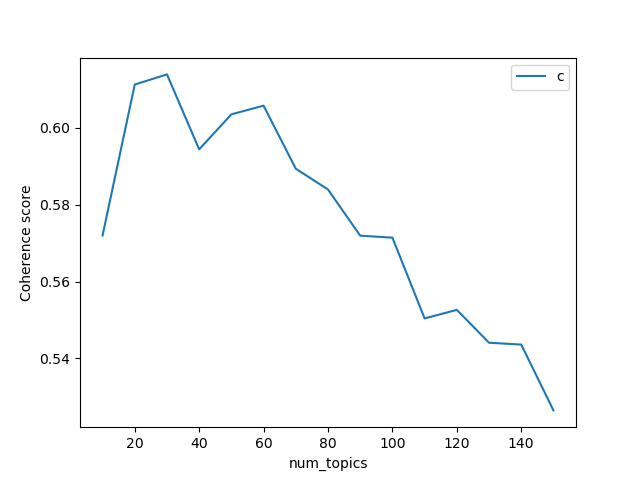

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = 'coherence_num_topic_05.03.png')

### 3.2. Berechnung des Modells mit 30 Topics 

In [ ]:
num_topics = 30
chunksize = 2000
passes = 100
iterations = 1000
eval_every = None
alpha = 1.0/30
eta = 1.0 /30

model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                                chunksize=chunksize,
                                alpha=alpha, eta=eta,
                                iterations=iterations,
                                passes=passes, eval_every=eval_every)

model.save('30_topics/lda_swrd_05_03_30t.model')

### 3.3. Auflistung aller Topics mit den jeweiligen Wortlisten 

In [12]:

model = models.LdaModel.load('30_topics/lda_swrd_05_03_30t.model')

for t,w in model.show_topics(num_topics=30, num_words=10, log=False, formatted=True):
    print ('Topic', t)
    print ('Words')
    print (w)


Topic 0
Words
0.147*"child" + 0.033*"welfare" + 0.030*"child_welfare" + 0.024*"protection" + 0.018*"worker" + 0.015*"child_protection" + 0.013*"service" + 0.012*"case" + 0.011*"system" + 0.010*"practice"
Topic 1
Words
0.131*"service" + 0.024*"agency" + 0.022*"need" + 0.020*"program" + 0.016*"management" + 0.015*"client" + 0.013*"case" + 0.013*"provider" + 0.012*"system" + 0.012*"delivery"
Topic 2
Words
0.033*"policy" + 0.032*"welfare" + 0.023*"service" + 0.017*"user" + 0.016*"change" + 0.014*"public" + 0.013*"state" + 0.013*"organization" + 0.011*"service_user" + 0.011*"reform"
Topic 3
Words
0.104*"state" + 0.063*"united" + 0.050*"united_state" + 0.043*"justice" + 0.022*"refugee" + 0.020*"juvenile" + 0.020*"offender" + 0.019*"criminal" + 0.018*"crime" + 0.018*"system"
Topic 4
Words
0.181*"family" + 0.106*"child" + 0.044*"parent" + 0.039*"foster" + 0.035*"care" + 0.017*"home" + 0.015*"placement" + 0.014*"foster_care" + 0.011*"problem" + 0.009*"support"
Topic 5
Words
0.066*"people" + 0.0

### 3.4 Erzeugung eines Datensatzes für die Zeitreihenanalyse 

In [ ]:
dictionary = gensim.corpora.Dictionary.load('30_topics/dictionary_swrd_30.dict')
corpus = corpora.MmCorpus('30_topics/corpus_swrd_30.mm')
model = models.LdaMulticore.load('30_topics/lda_swrd_05_03_30t.model')

df = pd.read_csv("SWRD_data_2017_clean.csv", sep="\t", encoding="utf-8")
df1 = df.groupby(['abstract']).filter(lambda df:df.shape[0] == 1)

list_lda_df = []
for index_doc,i in enumerate(model.get_document_topics(corpus)):
    #print(index_doc,i)
    lda_df = pd.DataFrame(i)
    lda_df["index_doc"] = index_doc
    lda_df2 = lda_df.set_index("index_doc")
    lda_df2["year"] = df1["pubYear"]
    lda_df2.rename(columns={0:"topic_id", 1:"topic_weight"}, inplace=True)
    list_lda_df.append(lda_df2)


df_lda = pd.concat(list_lda_df)

dtm = (df_lda.T/df_lda.sum(axis=1)).T
dt_norm = dtm.stack().reset_index()
dt_norm.columns = ['index_doc', 'topic_id', 'norm_topic_weight']

dt_norm2 = dt_norm[dt_norm["topic_id"] == "topic_weight"]
norm_topic_weight = dt_norm2["norm_topic_weight"].tolist()
df_lda["norm_topic_weight"] = norm_topic_weight

y_df = df_lda.groupby(["year","topic_id"]).agg({'norm_topic_weight': 'sum'})
ny_df = y_df.groupby(level=0).apply(lambda x: x / x.sum()).reset_index()

ny_df.to_csv("df_topic_nwy_30.csv", sep= '\t')

### 3.5 Visualisierung der Topics 

In [3]:
df = pd.read_csv("30_topics/df_topic_nwy_30.csv", sep= '\t')
df2 = df[df['year'] != 11992]
df2["year"] = df["year"].astype(int)


def create_pointplot(df, y_value, hue=None, order=None, col=None, wrap=None, size=6, aspect=1.5, title="",
                     new_title='', new_labels='', savename=''):


    p = sns.factorplot(x="year", y=y_value, kind='point', hue_order=order, hue=hue,
                       col=col, col_wrap=wrap, col_order=order, size=size, aspect=aspect,
                       data=df2, legend_out=True)
    p.fig.subplots_adjust(top=0.9)
    p.fig.suptitle(title, fontsize=16)
    p.set_xticklabels(rotation=30)
    p.set_xticklabels(step=2)
    p._legend.set_title(new_title)

    for t, l in zip(p._legend.texts, new_labels): t.set_text(l)
    p.savefig(savename, dpi=600)

    print(plt.show())

    return p




/home/eckl/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


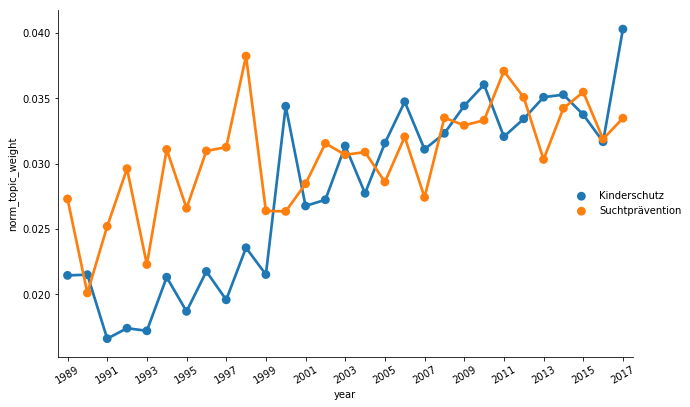

None


In [23]:
create_pointplot(df2, "norm_topic_weight", hue="topic_id", order=[0,19],
                 title="",
                 new_labels=["Kinderschutz", "Suchtprävention"], savename="Kinderschutz_Prävention.png")



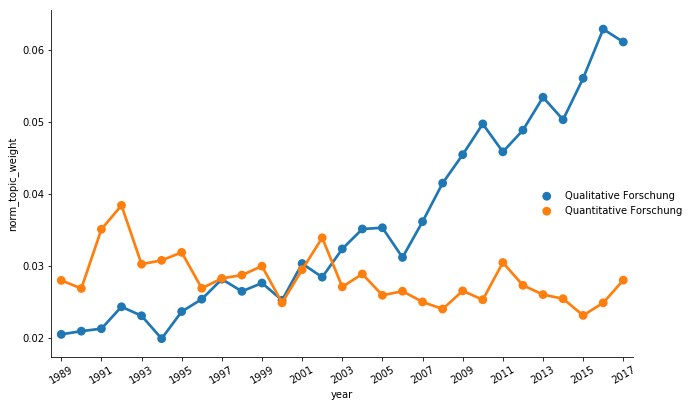

None


In [16]:

create_pointplot(df2, "norm_topic_weight", hue="topic_id", order=[18,28],
                 title="",
                 new_labels=["Qualitative Forschung","Quantitative Forschung"], savename="quali_quanti_Forschung.png")

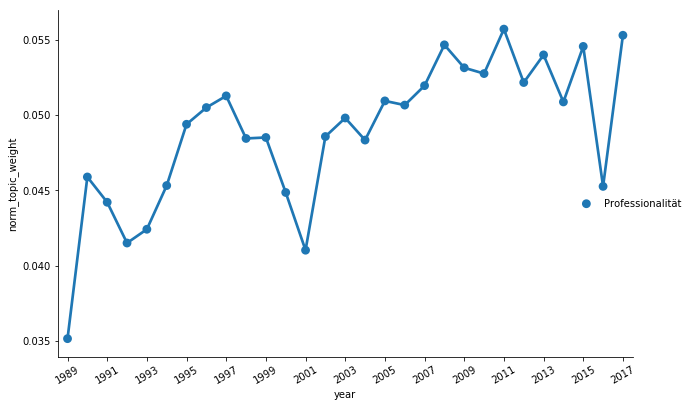

None


In [18]:
create_pointplot(df2, "norm_topic_weight", hue="topic_id", order=[16],
                 title="", new_title="" ,
                 new_labels=["Professionalität"], savename="Professionalität.png")